# Sarcasm Detection

https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home

Dataset provided by Rishabh Misra through Kaggle. The goal is to use the headline and contents of an article to predict whether or not it is sarcastic. 

The dataset is provided in  a JSON file. We will use the URLs to scrape the HTML for the headline and contents of the article.

In [ ]:
import zipfile

path = '/content/drive/MyDrive/Colab Notebooks/Sarcasm/Sarcasm_Headlines_Dataset.json.zip'
z = zipfile.ZipFile(path, 'r')
z.extractall('/tmp')
z.close()

In [ ]:
import json

def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('/tmp/Sarcasm_Headlines_Dataset.json'))

In [ ]:
data[0:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [ ]:
labels = []
urls = []
for record in data:
  labels.append(record['is_sarcastic'])
  urls.append(record['article_link'])

In [ ]:
n_articles = len(labels)
n_sarcastic = sum(labels)
print('There are {} articles in the dataset, of which {} are sarcastic (or {} percent)'.format(n_articles, n_sarcastic, round(n_sarcastic/n_articles,4)))

There are 26709 articles in the dataset, of which 11724 are sarcastic (or 0.439 percent)


We will use Beautiful Soup to parse the HTML. We will also preprocess the text data. This dataset only contains articles from The Onion and Huffpost, so we will remove reference to these publications in the text data.

In [ ]:
import re
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import html5lib
import unicodedata

def deEmojify(text): # thank you https://stackoverflow.com/users/6579239/abdul-razak-adam
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def clean_html(raw_html):
    tags = re.compile('<.*?>') # remove html tags and hyperrefs within text
    cleantext = ''
    for x in raw_html:
        cx = re.sub(tags, '', str(x))
        cleantext += ' ' + deEmojify(cx)
    cleantext = cleantext[1:].lower() # tokenizer converts to lower case as default
    publications = ['the onion', 'huffpost', '|'] # vertical bar appears frequently in Huffpost article titles
    for pub in publications:
      cleantext = cleantext.replace(pub, '')
    return cleantext 

def get_html_data(url):
    try:
      req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
      stream = urlopen(req,timeout = 5)
      html = stream.read()
      stream.close()
      html = html.decode('utf-8')
      soup = BeautifulSoup(html, 'html5lib')
      title = clean_html(soup.find_all('title'))
      paragraph = clean_html(soup.find_all('p'))
      text = paragraph.replace(b'\xe2\x80\x94'.decode('utf-8'), ' ') 
      # long dash character usually in the location at the beginning of an Onion article, remove so that network doesn't learn this
      contents = clean_html(soup.find_all('title') + soup.find_all('p')) 
      #return unicodedata.normalize('NFKD',contents)
      return title+ ' ' + text
      # replace unicode characters with equivalents
      # For example, \xa0 was in text data prior to normalization 
    except:
      # print('Failure to retrieve {}'.format(url))
      return None

The cell below gathers all of the text data from the articles. It is commented out since it takes a few hours to run. The text data has been saved in a pickle file.

In [ ]:
# import pickle

# article_data = []

# for i in range(n_articles):
  # article_data.append(get_html_data(urls[i])) # this process takes a few hours

# with open('/content/drive/MyDrive/Colab Notebooks/Sarcasm/article_data.pickle', 'wb') as f:
  # pickle.dump(article_data, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Sarcasm/article_data.pickle', 'rb') as f:
  article_data = pickle.load(f)

We failed to scrape data from some of the URLs in the dataset. We will remove these from the dataset.

In [ ]:
text_data = []
text_labels = []
for i, x in enumerate(article_data):
  if x != None:
    text_data.append(x)
    text_labels.append(labels[i])

In [ ]:
n_articles = len(text_labels)
n_sarcastic = sum(text_labels)
print('There are {} articles in the dataset, of which {} are sarcastic (or {} percent)'.format(n_articles, n_sarcastic, round(n_sarcastic/n_articles,4)))

There are 25714 articles in the dataset, of which 11720 are sarcastic (or 0.4558 percent)


Shuffle article data and labels prior to breaking into training and validation sets

In [ ]:
def shuffle_data(x,y):
  data = list(zip(x,y))
  random.shuffle(data)
  return zip(*data)

In [ ]:
import random
random.seed(737213)

article_data, labels = shuffle_data(text_data, text_labels)

n_training = int(n_articles*0.8) # 80% of data for training, 20% for validation

x_train = text_data[:n_training]
train_labels = text_labels[:n_training]
x_valid = text_data[n_training:]
valid_labels = text_labels[n_training:]

In [ ]:
# for preprocessing text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Parameters for tokenizing, padding, and truncating reviews that can be tuned

In [ ]:
vocab_size = 5000
maxlen = 25
trunc_type='post'
pad_type='post'
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

# switch key, value for the word index so that we can use the token (number) as the key
# look up the corresponding word
word_index = dict([(value,key) for key, value in word_index.items()])

x_train = tokenizer.texts_to_sequences(x_train)
x_valid = tokenizer.texts_to_sequences(x_valid)

x_train = pad_sequences(x_train, maxlen = maxlen,
                       padding = pad_type, truncating = trunc_type)
x_valid = pad_sequences(x_valid, maxlen = maxlen,
                       padding = pad_type, truncating = trunc_type)

Create Tensorflow Dataset objects to speed up training

In [ ]:
# for model setup and training
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Embedding, Dropout, Dense, Conv1D, GlobalMaxPooling1D,
                          Flatten, Bidirectional, LSTM, GRU, MaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

x_train = tf.data.Dataset.from_tensor_slices((x_train, train_labels)) 
x_valid = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))

train_data = x_train.shuffle(n_training).batch(128).prefetch(1)
valid_data = x_valid.shuffle(6000).batch(128).prefetch(1)

In [ ]:
import matplotlib.pyplot as plt

# for assessing model training and fit

def plot_training_metrics(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Acc')
  plt.plot(epochs_range, val_acc, label='Validation Acc')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Acc')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  plt.close()

In [ ]:
tf.keras.backend.clear_session()

embedding_dim = 20

conv_pool_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = maxlen), # improvement: could use pretrained word embeddings
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

conv_pool_model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

conv_pool_model.summary()

n_epochs = 5

conv_pool_history = conv_pool_model.fit(train_data, epochs = n_epochs,  validation_data = valid_data)

conv_pool_model.save('/content/drive/MyDrive/Colab Notebooks/Sarcasm/conv_pool_model')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 20)            100020    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 32)            3232      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2890      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 106,153
Trainable params: 106,153
Non-trainable params: 0
__________________________________________________

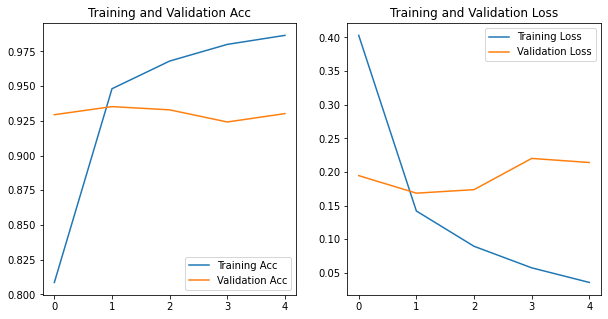

In [ ]:
plot_training_metrics(conv_pool_history)

In [ ]:
tf.keras.backend.clear_session()

embedding_dim = 20

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

n_epochs = 5

lstm_history = lstm_model.fit(train_data, epochs = n_epochs,  validation_data = valid_data)

Epoch 1/5
161/161 [==============================] - 5s 13ms/step - loss: 0.3483 - accuracy: 0.8390 - val_loss: 0.1868 - val_accuracy: 0.9296
Epoch 2/5
161/161 [==============================] - 1s 9ms/step - loss: 0.1332 - accuracy: 0.9521 - val_loss: 0.1751 - val_accuracy: 0.9314
Epoch 3/5
161/161 [==============================] - 1s 9ms/step - loss: 0.0825 - accuracy: 0.9707 - val_loss: 0.1678 - val_accuracy: 0.9419
Epoch 4/5
161/161 [==============================] - 1s 9ms/step - loss: 0.0472 - accuracy: 0.9853 - val_loss: 0.1969 - val_accuracy: 0.9388
Epoch 5/5
161/161 [==============================] - 1s 9ms/step - loss: 0.0313 - accuracy: 0.9904 - val_loss: 0.2217 - val_accuracy: 0.9403


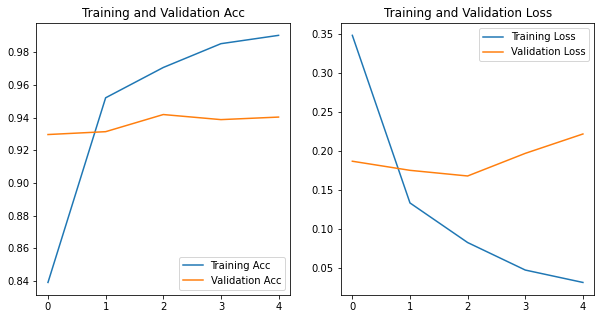

In [ ]:
plot_training_metrics(lstm_history)

In [ ]:
tf.keras.backend.clear_session()

embedding_dim = 20

hybrid_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

hybrid_model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

hybrid_history = hybrid_model.fit(train_data, epochs = n_epochs,  validation_data = valid_data)

Epoch 1/5
161/161 [==============================] - 4s 12ms/step - loss: 0.3480 - accuracy: 0.8273 - val_loss: 0.2045 - val_accuracy: 0.9185
Epoch 2/5
161/161 [==============================] - 1s 8ms/step - loss: 0.1267 - accuracy: 0.9536 - val_loss: 0.1692 - val_accuracy: 0.9337
Epoch 3/5
161/161 [==============================] - 1s 9ms/step - loss: 0.0683 - accuracy: 0.9783 - val_loss: 0.1991 - val_accuracy: 0.9362
Epoch 4/5
161/161 [==============================] - 1s 8ms/step - loss: 0.0342 - accuracy: 0.9906 - val_loss: 0.2294 - val_accuracy: 0.9366
Epoch 5/5
161/161 [==============================] - 1s 8ms/step - loss: 0.0192 - accuracy: 0.9950 - val_loss: 0.2906 - val_accuracy: 0.9236


In [ ]:
# predictions
def is_article_sarcastic(model, article_urls):
  text_data = []
  for url in article_urls:
    text_data.append(get_html_data(url))
  x = tokenizer.texts_to_sequences(text_data)
  x = pad_sequences(x, maxlen = maxlen,
                    padding=pad_type, truncating = trunc_type)
  probs = model.predict(x)
  for i, prob in enumerate(probs):
    if prob > 0.5:
      label = 'sarcastic'
      p = prob
    else:
      label = 'NOT sarcastic'
      p = 1 - prob
    p = round(float(p),4)
    print('The article \n -- {} -- \n is predicted to be {} with probability {} \n'.format(article_urls[i],label, p))

In [ ]:
urls = ['https://www.poughkeepsiejournal.com/story/news/education/2021/04/08/marist-covid-outbreak-person-classes-resume-monday/7149672002/',
        'https://reductress.com/post/cold-woman-regrets-removing-arm-hair/',
        'https://reductress.com/post/immigrant-parents-negotiating-with-cashier-at-marshalls-again/',
        'https://www.nytimes.com/2021/07/09/technology/biden-tech-executive-order.html?action=click&module=Top%20Stories&pgtype=Homepage']
is_article_sarcastic(lstm_model, urls)

The article 
 -- https://www.poughkeepsiejournal.com/story/news/education/2021/04/08/marist-covid-outbreak-person-classes-resume-monday/7149672002/ -- 
 is predicted to be NOT sarcastic with probability 0.9279 

The article 
 -- https://reductress.com/post/cold-woman-regrets-removing-arm-hair/ -- 
 is predicted to be sarcastic with probability 0.9398 

The article 
 -- https://reductress.com/post/immigrant-parents-negotiating-with-cashier-at-marshalls-again/ -- 
 is predicted to be sarcastic with probability 0.9979 

The article 
 -- https://www.nytimes.com/2021/07/09/technology/biden-tech-executive-order.html?action=click&module=Top%20Stories&pgtype=Homepage -- 
 is predicted to be NOT sarcastic with probability 0.9756 



In [ ]:
# predictions
def is_text_sarcastic(model, comments):
  x = tokenizer.texts_to_sequences(comments)
  x = pad_sequences(x, maxlen = maxlen,
                    padding=pad_type, truncating = trunc_type)
  probs = model.predict(x)
  for i, prob in enumerate(probs):
    if prob > 0.5:
      label = 'sarcastic'
      p = prob
    else:
      label = 'NOT sarcastic'
      p = 1 - prob
    p = round(float(p),4)
    print('The text \n -- {} -- \n is predicted to be {} with probability {} \n'.format(comments[i],label, p))

In [ ]:
comments = ['I’m not saying I hate you, what I’m saying is that you are literally the Monday of my life',
            'The Brooklyn Nets are finalizing a deal with David Vanterpool to become an assistant coach, sources tell ESPN.',
            'What were you doing under our window, boy? Listening to the news said Harry in a resigned voice. His aunt and uncle exchanged looks of outrage. Listening to the news! Again? Well, it changes every day, you see, said Harry.',
            'remember like two weeks ago when conservatives tried to convince us that infrastructure had nothing to do with the climate crisis',
            'It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of Light, it was the season of Darkness, it was the spring of hope, it was the winter of despair.',
            'I wanted you to see what real courage is, instead of getting the idea that courage is a man with a gun in his hand. It’s when you know you’re licked before you begin, but you begin anyway and see it through no matter what.'
            ]
is_text_sarcastic(lstm_model, comments)

The text 
 -- I’m not saying I hate you, what I’m saying is that you are literally the Monday of my life -- 
 is predicted to be sarcastic with probability 0.9049 

The text 
 -- The Brooklyn Nets are finalizing a deal with David Vanterpool to become an assistant coach, sources tell ESPN. -- 
 is predicted to be sarcastic with probability 0.824 

The text 
 -- What were you doing under our window, boy? Listening to the news said Harry in a resigned voice. His aunt and uncle exchanged looks of outrage. Listening to the news! Again? Well, it changes every day, you see, said Harry. -- 
 is predicted to be NOT sarcastic with probability 0.9999 

The text 
 -- remember like two weeks ago when conservatives tried to convince us that infrastructure had nothing to do with the climate crisis -- 
 is predicted to be sarcastic with probability 0.5251 

The text 
 -- It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of be